In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb

from xgboost import XGBClassifier

from datetime import datetime,timedelta

import os
os.chdir('../Python')
from utilities import *
os.chdir('../development')

# Loading data

In [36]:
data = load("../Generated Data/atp_data_f")
features=load("../Generated Data/atp_data_features")
eval_odds=load("../Generated Data/eval_odds")

In [653]:
def get_cals_to_drop(start_date,nb_players,nb_tournaments):
    
    test_beginning_match=data[data.Date>=start_date].index[0] #id of the first match of the testing set
    span_matches=len(data)-test_beginning_match+1
    #duration_val_matches=700 + 10
    duration_val_matches=300 
    duration_train_matches=10400
    #duration_train_matches=12122
    duration_test_matches=500
    
    # Number of matches in our dataset (ie. nb. of outcomes divided by 2)
    nm=int(len(features)/2)

    # Id of the first and last match of the testing,validation,training set
    beg_test=test_beginning_match
    end_test=min(test_beginning_match+duration_test_matches-1,nm-1)
    end_val=min(beg_test-1,nm-1)
    beg_val=beg_test-duration_val_matches
    end_train=beg_val-1
    beg_train=beg_val-duration_train_matches
    
    # We limit the number of players and tournaments one-hot encoded : we'll keep only the 
    # players that won the most matches to avoid overfitting and make the process quicker
    # Biggest players :
    biggest_players=data.iloc[range(beg_train,end_train),:][["Winner","Loser"]]
    biggest_players=pd.concat([biggest_players.Winner,biggest_players.Loser],0)
    biggest_players=list(biggest_players.value_counts().index[:nb_players])
    player_columns=[el for el in xtrain.columns if el[:6]=="player"]
    to_drop_players=[el for el in player_columns if el[7:] not in biggest_players]
    # Biggest Tournaments
    biggest_tournaments=data.iloc[range(beg_train,end_train),:]["Tournament"]
    biggest_tournaments=list(biggest_tournaments.value_counts().index[:nb_tournaments])
    tournament_columns=[el for el in xtrain.columns if el[:10]=="tournament"]
    to_drop_tournaments=[el for el in tournament_columns if el[11:] not in biggest_tournaments]
    
    return to_drop_players, to_drop_tournaments
    

In [654]:
def make_split(days_diff,to_drop_players, to_drop_tournaments, start_date):
    
    
    #start_date=datetime(2016,2,1) #first day of testing set
    test_beginning_match=data[data.Date>=start_date].index[0] #id of the first match of the testing set
    span_matches=len(data)-test_beginning_match+1
    #duration_val_matches=700 + 10
    duration_val_matches=300 + days_diff
    duration_train_matches=10400
    #duration_train_matches=12122
    duration_test_matches=500
    
    # Number of matches in our dataset (ie. nb. of outcomes divided by 2)
    nm=int(len(features)/2)

    # Id of the first and last match of the testing,validation,training set
    beg_test=test_beginning_match
    end_test=min(test_beginning_match+duration_test_matches-1,nm-1)
    end_val=min(beg_test-1,nm-1)
    beg_val=beg_test-duration_val_matches
    end_train=beg_val-1
    beg_train=beg_val-duration_train_matches
    
    global train_indices
    global val_indices
    global test_indices
    global xtest

    train_indices=range(2*beg_train,2*end_train+2)
    val_indices=range(2*beg_val,2*end_val+2)
    test_indices=range(2*beg_test,2*end_test+2)
    


    # Split in train/validation/test
    xval=features.iloc[val_indices,:].reset_index(drop=True)
    xtest=features.iloc[test_indices,:].reset_index(drop=True)
    xtrain=features.iloc[train_indices,:].reset_index(drop=True)
    ytrain=pd.Series([1,0]*int(len(train_indices)/2))
    yval=pd.Series([1,0]*int(len(val_indices)/2))
    
    '''
    # We limit the number of players and tournaments one-hot encoded : we'll keep only the 
    # players that won the most matches to avoid overfitting and make the process quicker
    # Biggest players :
    biggest_players=data.iloc[range(beg_train,end_train),:][["Winner","Loser"]]
    biggest_players=pd.concat([biggest_players.Winner,biggest_players.Loser],0)
    biggest_players=list(biggest_players.value_counts().index[:nb_players])
    player_columns=[el for el in xtrain.columns if el[:6]=="player"]
    to_drop_players=[el for el in player_columns if el[7:] not in biggest_players]
    # Biggest Tournaments
    biggest_tournaments=data.iloc[range(beg_train,end_train),:]["Tournament"]
    biggest_tournaments=list(biggest_tournaments.value_counts().index[:nb_tournaments])
    tournament_columns=[el for el in xtrain.columns if el[:10]=="tournament"]
    to_drop_tournaments=[el for el in tournament_columns if el[11:] not in biggest_tournaments]
    # We drop smallest Tournaments and players
    '''
    xtrain=xtrain.drop(to_drop_players+to_drop_tournaments,1)
    xval=xval.drop(to_drop_players+to_drop_tournaments,1)
    xtest=xtest.drop(to_drop_players+to_drop_tournaments,1)
    
    
    
    
    
    
    return xtrain, ytrain, xval, yval, xtest, train_indices, val_indices, test_indices
    
    #return xtrain, ytrain, xval, yval, xtest


In [14]:
len(train_indices)

24244

In [7]:
xtrain, ytrain, xval, yval, xtest, train_indices, val_indices, test_indices = make_split(5)

In [39]:

## XGB parameters
#learning_rate=[0.295] 
learning_rate=[0.3] 
max_depth=[19]
#max_depth=[10]
min_child_weight=[1]
gamma=[0.8]
csbt=[0.5]
lambd=[0]
alpha=[2]
#alpha=[1]
num_rounds=[300]
early_stop=[10]
params=np.array(np.meshgrid(learning_rate,max_depth,min_child_weight,gamma,csbt,lambd,alpha,num_rounds,early_stop)).T.reshape(-1,9).astype(np.float)
#xgb_params=params[0]
p=params[0]


def evalerror(preds, dtrain):
#thr = 0.5
    #labels = dtrain.get_label()
    global eval_odds
    global train_indices
    global val_indices
    global test_indices


    if len(preds) == len(train_indices):
        odds = eval_odds[train_indices]
        gain = odds * preds       
    elif len(preds) == len(val_indices):
        odds = eval_odds[val_indices]
        gain = odds * preds 
    elif len(preds) == len(test_indices):
        odds = eval_odds[test_indices]
        gain = odds * preds 
    else:
        return 'function_error', 0

    
    #print(preds.shape)
    
    #return 'neg_gain_error', 0

    return 'neg_gain_error', -gain.sum()




dtrain=xgb.DMatrix(xtrain,label=ytrain)

#the_metric = "logloss"
#the_metric = "error"
#the_metric = "auc"
#the_metric = ["error","auc"]
the_metric = 'evalerror'

dval=xgb.DMatrix(xval,label=yval)
eval_set = [(dtrain,"train_loss"),(dval, 'eval')]
#eval_set = [(dval, 'eval')]
#params={'eval_metric':the_metric,"objective":"binary:logistic",'subsample':0.8,
#        'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
#        'gamma':p[3],'eta':p[0],'colsample_bytree':p[4]}
#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

params={"objective":"binary:logistic",'subsample':0.8,
        'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
        'gamma':p[3],'eta':p[0],'colsample_bytree':p[4],  'disable_default_eval_metric' : 1}
#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), eval_metric = evalerror)
model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), feval = evalerror)
#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))


[0]	train_loss-neg_gain_error:-110.61	eval-neg_gain_error:15.8456
Multiple eval metrics have been passed: 'eval-neg_gain_error' will be used for early stopping.

Will train until eval-neg_gain_error hasn't improved in 10 rounds.
[1]	train_loss-neg_gain_error:-570.352	eval-neg_gain_error:12.8859
[2]	train_loss-neg_gain_error:-970.036	eval-neg_gain_error:13.3708
[3]	train_loss-neg_gain_error:-1366.11	eval-neg_gain_error:11.8475
[4]	train_loss-neg_gain_error:-1761.72	eval-neg_gain_error:12.0528
[5]	train_loss-neg_gain_error:-2126.39	eval-neg_gain_error:10.9817
[6]	train_loss-neg_gain_error:-2429.23	eval-neg_gain_error:12.5219
[7]	train_loss-neg_gain_error:-2700.23	eval-neg_gain_error:11.7474
[8]	train_loss-neg_gain_error:-2948.49	eval-neg_gain_error:10.5577
[9]	train_loss-neg_gain_error:-3167.83	eval-neg_gain_error:9.65078
[10]	train_loss-neg_gain_error:-3371.46	eval-neg_gain_error:8.85426
[11]	train_loss-neg_gain_error:-3588.64	eval-neg_gain_error:9.93691
[12]	train_loss-neg_gain_error:-

In [883]:
def get_trained_model(days_diff,to_drop_players, to_drop_tournaments,start_date):
    xtrain, ytrain, xval, yval, xtest, train_indices, val_indices, test_indices = make_split(days_diff,to_drop_players, to_drop_tournaments,start_date)
    
    global p
    
    ## XGB parameters
    #learning_rate=[0.295] 
    learning_rate=[0.5] 
    #max_depth=[19]
    #max_depth=[10]
    max_depth=[100]
    min_child_weight=[1]
    gamma=[0.8]
    csbt=[0.5]
    lambd=[0]
    alpha=[2]
    #alpha=[1]
    num_rounds=[300]
    early_stop=[5]
    params=np.array(np.meshgrid(learning_rate,max_depth,min_child_weight,gamma,csbt,lambd,alpha,num_rounds,early_stop)).T.reshape(-1,9).astype(np.float)
    #xgb_params=params[0]
    p=params[0]


    def evalerror_inner(preds_in, dtrain):
        thr = 0.65
        #labels = dtrain.get_label()
        global eval_odds
        global train_indices
        global val_indices
        global test_indices
        
        preds_dec = np.zeros(len(preds_in))
        
        for k in range(0,len(preds_in)-1,2):
            if preds_in[k]>preds_in[k+1]:
                preds_dec[k] = preds_in[k]
                preds_dec[k+1] = 0
            else:
                preds_dec[k] = 0
                preds_dec[k+1] = preds_in[k+1]
        
        preds = np.array([1 if p_i>=thr else 0 for p_i in preds_dec])
        
        #print(f'Preds1 {preds_in[0:10]}')
        #print(f'Preds1 {preds_dec[0:10]}')
        #print(f'Preds1 {preds[0:10]}')


        if len(preds) == len(train_indices):
            odds = eval_odds[train_indices]
            gain = odds * preds       
            reachable = odds.sum()+(len(train_indices)/2)
            current_roi = round(gain.sum()/preds.sum(),3)
            print(f'Max reachable train loss: {-reachable} Train ROI: {current_roi}% Number of bets: {preds.sum()}')
            return 'train_gain_error', -gain.sum()
        elif len(preds) == len(val_indices):
            odds = eval_odds[val_indices]
            gain = odds * preds 
            reachable = odds.sum()+(len(val_indices)/2)
            current_roi = round(gain.sum()/preds.sum(),3)
            print(f'Max reachable eval  loss: {-reachable}  Eval ROI: {current_roi}% Number of bets: {preds.sum()}')
            print(f'Val Preds {preds[0:10]} Threshold: {thr}')
            return 'val_gain_error', -gain.sum()
        elif len(preds) == len(test_indices):
            odds = eval_odds[test_indices]
            gain = odds * preds 
            return 'test_gain_error', -gain.sum()
        else:
            return 'function_error', 0


        #print(preds.shape)

        #return 'neg_gain_error', 0

        #return 'neg_gain_error', -gain.sum()
        
    #xtrain.drop(['odds', 'odds_opp'], axis = 1, inplace = True)
    #xval.drop(['odds', 'odds_opp'], axis = 1,inplace = True)
    #xtest.drop(['odds', 'odds_opp'], axis = 1,inplace = True)



    dtrain=xgb.DMatrix(xtrain,label=ytrain)

    the_metric = "logloss"
    #the_metric = "error"
    #the_metric = "auc"
    #the_metric = ["error","auc"]
    #the_metric = 'evalerror'
    

    dval=xgb.DMatrix(xval,label=yval)
    eval_set = [(dtrain,"train_loss"),(dval, 'eval')]
    #eval_set = [(dval, 'eval')]
    #params={'eval_metric':the_metric,"objective":"binary:logistic",'subsample':0.8,
    #        'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
    #        'gamma':p[3],'eta':p[0],'colsample_bytree':p[4],  'disable_default_eval_metric' : 0}
    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

    params={"objective":"binary:logistic",'subsample':0.8,
            'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
            'gamma':p[3],'eta':p[0],'colsample_bytree':p[4],  'disable_default_eval_metric' : 1}
    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), eval_metric = evalerror)
    model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), feval = evalerror_inner)
    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))
    
    eval_predict = model.predict(dval)
    evalscore = evalerror_inner(eval_predict,dtrain)

    return model, train_indices, val_indices, test_indices , xtest, evalscore[1]

In [865]:
p

array([2.95e-01, 5.00e+01, 1.00e+00, 8.00e-01, 5.00e-01, 0.00e+00,
       2.00e+00, 3.00e+02, 1.50e+01])

In [699]:
start_date=datetime(2017,5,1) #first day of testing set

to_drop_players, to_drop_tournaments= get_cals_to_drop(start_date,200,200)
    
    


model1, train_indices, val_indices, test_indices, xtest, evalscore1 = get_trained_model(0,to_drop_players, to_drop_tournaments,start_date)
model2, train_indices, val_indices, test_indices, xtest, evalscore2 = get_trained_model(10,to_drop_players, to_drop_tournaments,start_date)
model3, train_indices, val_indices, test_indices, xtest, evalscore3 = get_trained_model(-10,to_drop_players, to_drop_tournaments,start_date)
model4, train_indices, val_indices, test_indices, xtest, evalscore4 = get_trained_model(30,to_drop_players, to_drop_tournaments,start_date)
model5, train_indices, val_indices, test_indices, xtest, evalscore5 = get_trained_model(-30,to_drop_players, to_drop_tournaments,start_date)
model6, train_indices, val_indices, test_indices, xtest, evalscore6 = get_trained_model(45,to_drop_players, to_drop_tournaments,start_date)
model7, train_indices, val_indices, test_indices, xtest, evalscore7 = get_trained_model(-45,to_drop_players, to_drop_tournaments,start_date)
model8, train_indices, val_indices, test_indices, xtest, evalscore8 = get_trained_model(17,to_drop_players, to_drop_tournaments,start_date)
model9, train_indices, val_indices, test_indices, xtest, evalscore9 = get_trained_model(-17,to_drop_players, to_drop_tournaments,start_date)



clf_list = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
classif = VotingClassifier(clf_list)
xtest_0=features.iloc[test_indices,:].reset_index(drop=True)
#Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf= classif.predict(xtest, 0.7, vote_thr = (7/9))
y_mean,  y_voting, y_mean_pr_conf, y_mean_conf, y_voting_conf = classif.predict(xtest, 0.7, vote_thr = (7/9), conf_thr = 0.7)


print(evalerror(y_voting, dtrain))
print(evalerror(y_mean, dtrain))
print(evalerror(y_mean_conf, dtrain))
print(evalerror(y_voting_conf, dtrain))

Preds1 [0.5        0.5        0.57665277 0.5        0.4598593  0.5
 0.5        0.5587277  0.5909254  0.40320414]
Preds1 [0.         0.5        0.57665277 0.         0.         0.5
 0.         0.55872768 0.5909254  0.        ]
Preds1 [0 1 1 0 0 1 0 1 1 0]
Max reachable train loss: -9713.19 Train ROI: 0.161% Number of bets: 10052
Preds1 [0.5628796  0.43335354 0.39928108 0.601807   0.47894102 0.6013785
 0.5732198  0.45795664 0.6021436  0.40320414]
Preds1 [0.56287962 0.         0.         0.601807   0.         0.6013785
 0.57321978 0.         0.60214359 0.        ]
Preds1 [1 0 0 1 0 1 1 0 1 0]
Max reachable eval  loss: -312.36  Eval ROI: -0.03% Number of bets: 282
Val Preds [1 0 0 1 0 1 1 0 1 0] Threshold: 0.5
[0]	train_loss-train_gain_error:-1618.48	eval-val_gain_error:8.53
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Preds1 [0.5        0.5        0.63421375 0.3984463  0.51

KeyboardInterrupt: 

In [ ]:
res =[]
for i in range(2014,2017,1):
    for j in range(1,13):
        start_date=datetime(i,j,1) #first day of testing set
        print(start_date)

        to_drop_players, to_drop_tournaments= get_cals_to_drop(start_date,200,200)
        
        
        threshold_test = 0.65
        threshold_test_conf = 0.65
        req_votes = 7/9
        threshold_test_log_odd = 1.4
        
        threshold_train = 0.65 # !!! Not passed to function, just for saving info!
    


        model1, train_indices, val_indices, test_indices, xtest, evalscore1 = get_trained_model(0,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model2, train_indices, val_indices, test_indices, xtest, evalscore2 = get_trained_model(10,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model3, train_indices, val_indices, test_indices, xtest, evalscore3 = get_trained_model(-10,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model4, train_indices, val_indices, test_indices, xtest, evalscore4 = get_trained_model(30,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model5, train_indices, val_indices, test_indices, xtest, evalscore5 = get_trained_model(-30,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model6, train_indices, val_indices, test_indices, xtest, evalscore6 = get_trained_model(45,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model7, train_indices, val_indices, test_indices, xtest, evalscore7 = get_trained_model(-45,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model8, train_indices, val_indices, test_indices, xtest, evalscore8 = get_trained_model(17,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model9, train_indices, val_indices, test_indices, xtest, evalscore9 = get_trained_model(-17,to_drop_players, to_drop_tournaments,start_date)



        clf_list = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
        classif = VotingClassifier(clf_list)
        xtest_0=features.iloc[test_indices,:].reset_index(drop=True)
        #Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf= classif.predict(xtest, 0.7, vote_thr = (7/9))
        #y_mean,  y_voting, y_mean_pr_conf, y_mean_conf, y_voting_conf = classif.predict(xtest, threshold_test, vote_thr = req_votes, conf_thr = threshold_test_conf)
        y_mean,  y_voting, y_mean_conf, y_voting_conf, y_mean_log_odd, y_voting_log_odd = classif.predict(xtest, threshold_test, vote_thr = req_votes, conf_thr = threshold_test_conf, log_odd_thr = threshold_test_log_odd)
        result = [start_date, evalerror(y_voting, dtrain), evalerror(y_mean, dtrain),evalerror(y_voting_conf, dtrain), evalerror(y_mean_conf, dtrain), evalerror(y_voting_log_odd, dtrain), evalerror(y_mean_log_odd, dtrain), y_voting.sum(), y_mean.sum(), y_voting_conf.sum(),y_mean_conf.sum(), y_voting_log_odd.sum(),y_mean_log_odd.sum()]
        
        res.append(result)
        
        print(f'y_voting:         {evalerror(y_voting, dtrain)[1]}')
        print(f'y_mean:           {evalerror(y_mean, dtrain)[1]}')
        print(f'y_voting_conf:    {evalerror(y_voting_conf, dtrain)[1]}')
        print(f'y_mean_conf:      {evalerror(y_mean_conf, dtrain)[1]}')
        print(f'y_voting_log_odd: {evalerror(y_voting_log_odd, dtrain)[1]}')
        print(f'y_mean_log_odd:   {evalerror(y_mean_log_odd, dtrain)[1]}')

        res_cols = 6
        
        f1 = np.zeros((len(res),res_cols))
        f2 = np.zeros((len(res),res_cols))
        for r in range(res_cols):
            f1[:,r] = np.array([row[r+1][1] for row in res])
            f2[:,r] = f1[:,r].cumsum()
        
        print(f1)
        print(f2)
#post_fix = "_test6" nicht nochmal
post_fix = "_test9"      

para_str = "train_test_results" + post_fix + "_info"
res_str = "train_test_results" + post_fix
parameters = [threshold_test, threshold_test_conf, req_votes,threshold_test_log_odd, threshold_train, p]        
dump(parameters,para_str)
dump(res,res_str)

2014-01-01 00:00:00


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Max reachable train loss: -9561.1 Train ROI: 0.178% Number of bets: 4443
Max reachable eval  loss: -271.94  Eval ROI: 0.037% Number of bets: 118
Val Preds [0 0 0 0 0 1 1 0 0 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-790.444	eval-val_gain_error:-4.38
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9561.1 Train ROI: 0.291% Number of bets: 6555
Max reachable eval  loss: -271.94  Eval ROI: 0.075% Number of bets: 164
Val Preds [0 1 0 0 0 1 1 0 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1905.8	eval-val_gain_error:-12.35
Max reachable train loss: -9561.1 Train ROI: 0.372% Number of bets: 7301
Max reachable eval  loss: -271.94  Eval ROI: 0.046% Number of bets: 178
Val Preds [0 1 0 1 0 1 1 0 0 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2713.39	eval-val_gain_error:-8.19
Max reachable train loss: -9561.1 Train ROI: 0.412% Number

Max reachable train loss: -9565.04 Train ROI: 0.646% Number of bets: 9159
Max reachable eval  loss: -258.0  Eval ROI: 0.005% Number of bets: 216
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.65
[10]	train_loss-train_gain_error:-5915.19	eval-val_gain_error:-1.07
Max reachable train loss: -9565.04 Train ROI: 0.663% Number of bets: 9266
Max reachable eval  loss: -258.0  Eval ROI: -0.009% Number of bets: 213
Val Preds [1 0 0 1 1 0 0 0 1 0] Threshold: 0.65
[11]	train_loss-train_gain_error:-6144.9	eval-val_gain_error:1.82
Max reachable train loss: -9565.04 Train ROI: 0.676% Number of bets: 9378
Max reachable eval  loss: -258.0  Eval ROI: 0.008% Number of bets: 214
Val Preds [1 0 0 1 1 0 0 0 1 0] Threshold: 0.65
[12]	train_loss-train_gain_error:-6338	eval-val_gain_error:-1.75
Max reachable train loss: -9565.04 Train ROI: 0.683% Number of bets: 9447
Max reachable eval  loss: -258.0  Eval ROI: 0.013% Number of bets: 213
Val Preds [1 0 0 1 1 0 0 0 1 0] Threshold: 0.65
[13]	train_loss-train_gain_e

Max reachable train loss: -9564.83 Train ROI: 0.29% Number of bets: 6533
Max reachable eval  loss: -313.21  Eval ROI: 0.085% Number of bets: 205
Val Preds [0 0 0 0 1 0 0 1 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1896.19	eval-val_gain_error:-17.36
Max reachable train loss: -9564.83 Train ROI: 0.361% Number of bets: 7384
Max reachable eval  loss: -313.21  Eval ROI: 0.026% Number of bets: 227
Val Preds [0 0 0 0 1 0 0 1 0 1] Threshold: 0.65
[2]	train_loss-train_gain_error:-2665.86	eval-val_gain_error:-5.82
Max reachable train loss: -9564.83 Train ROI: 0.397% Number of bets: 7734
Max reachable eval  loss: -313.21  Eval ROI: 0.06% Number of bets: 235
Val Preds [0 0 0 0 1 0 0 1 0 1] Threshold: 0.65
[3]	train_loss-train_gain_error:-3067.13	eval-val_gain_error:-14.07
Max reachable train loss: -9564.83 Train ROI: 0.45% Number of bets: 8083
Max reachable eval  loss: -313.21  Eval ROI: 0.04% Number of bets: 235
Val Preds [0 0 0 0 1 0 0 1 0 0] Threshold: 0.65
[4]	train_loss-train_gain

Max reachable train loss: -9562.35 Train ROI: 0.568% Number of bets: 8702
Max reachable eval  loss: -253.69  Eval ROI: 0.002% Number of bets: 199
Val Preds [0 1 0 0 0 0 1 0 1 0] Threshold: 0.65
[7]	train_loss-train_gain_error:-4943.56	eval-val_gain_error:-0.41
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2795.04	eval-val_gain_error:-4.96

Max reachable eval  loss: -253.69  Eval ROI: 0.002% Number of bets: 199
Val Preds [0 1 0 0 0 0 1 0 1 0] Threshold: 0.65
y_voting:         9.639999999999999
y_mean:           15.34
y_voting_conf:    4.320000000000001
y_mean_conf:      5.740000000000001
y_voting_log_odd: 6.38
y_mean_log_odd:   12.479999999999999
[[ 9.64 15.34  4.32  5.74  6.38 12.48]]
[[ 9.64 15.34  4.32  5.74  6.38 12.48]]
2014-02-01 00:00:00
Max reachable train loss: -9585.368 Train ROI: 0.223% Number of bets: 4328
Max reachable eval  loss: -278.58  Eval ROI: -0.004% Number of bets: 144
Val Preds [0 1 1 0 1 0 0 0 0 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-966.

Max reachable train loss: -9574.803 Train ROI: 0.412% Number of bets: 7729
Max reachable eval  loss: -314.87  Eval ROI: -0.033% Number of bets: 223
Val Preds [0 1 0 0 0 0 0 1 1 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3184.16	eval-val_gain_error:7.42
Max reachable train loss: -9574.803 Train ROI: 0.461% Number of bets: 8042
Max reachable eval  loss: -314.87  Eval ROI: -0.066% Number of bets: 225
Val Preds [0 1 0 0 1 0 0 1 0 1] Threshold: 0.65
[4]	train_loss-train_gain_error:-3708.92	eval-val_gain_error:14.84
Max reachable train loss: -9574.803 Train ROI: 0.507% Number of bets: 8329
Max reachable eval  loss: -314.87  Eval ROI: -0.067% Number of bets: 232
Val Preds [0 1 0 0 1 0 0 1 0 1] Threshold: 0.65
[5]	train_loss-train_gain_error:-4224.01	eval-val_gain_error:15.65
Max reachable train loss: -9574.803 Train ROI: 0.535% Number of bets: 8511
Max reachable eval  loss: -314.87  Eval ROI: -0.087% Number of bets: 236
Val Preds [0 1 0 0 1 0 0 1 0 1] Threshold: 0.65
[6]	train_loss-t

Max reachable train loss: -9576.065 Train ROI: 0.529% Number of bets: 8389
Max reachable eval  loss: -247.87  Eval ROI: -0.068% Number of bets: 178
Val Preds [0 0 1 0 1 0 1 0 0 1] Threshold: 0.65
[6]	train_loss-train_gain_error:-4435.18	eval-val_gain_error:12.03
Max reachable train loss: -9576.065 Train ROI: 0.56% Number of bets: 8597
Max reachable eval  loss: -247.87  Eval ROI: -0.064% Number of bets: 177
Val Preds [0 0 1 0 1 0 1 0 0 1] Threshold: 0.65
[7]	train_loss-train_gain_error:-4814.87	eval-val_gain_error:11.38
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2509.6	eval-val_gain_error:5.41

Max reachable eval  loss: -247.87  Eval ROI: -0.064% Number of bets: 177
Val Preds [0 0 1 0 1 0 1 0 0 1] Threshold: 0.65
2014-02-01 00:00:00
Max reachable train loss: -9580.222 Train ROI: 0.178% Number of bets: 4502
Max reachable eval  loss: -297.19  Eval ROI: 0.012% Number of bets: 142
Val Preds [0 0 0 0 0 0 1 0 0 1] Threshold: 0.65
[0]	train_loss-train_gain_error:-802.971	eval-v

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9608.687 Train ROI: 0.289% Number of bets: 6433
Max reachable eval  loss: -264.53999999999996  Eval ROI: -0.033% Number of bets: 176
Val Preds [0 0 0 0 0 1 0 0 1 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1856.09	eval-val_gain_error:5.74
Max reachable train loss: -9608.687 Train ROI: 0.366% Number of bets: 7322
Max reachable eval  loss: -264.53999999999996  Eval ROI: -0.005% Number of bets: 178
Val Preds [0 0 0 0 0 1 0 0 0 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2677.93	eval-val_gain_error:0.96
Max reachable train loss: -9608.687 Train ROI: 0.414% Number of bets: 7786
Max reachable eval  loss: -264.53999999999996  Eval ROI: 0.043% Number of bets: 202
Val Preds [0 1 1 0 0 1 0 0 0 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3226.96	eval-val_gain_error:-8.75
Max reachable train loss: -9608.687 Train ROI: 0.458% Number of bets: 8116
Max reachable eval  loss: -264.539999

Max reachable train loss: -9616.533 Train ROI: 0.353% Number of bets: 7383
Max reachable eval  loss: -220.52  Eval ROI: 0.032% Number of bets: 172
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2608.54	eval-val_gain_error:-5.44
Max reachable train loss: -9616.533 Train ROI: 0.416% Number of bets: 7713
Max reachable eval  loss: -220.52  Eval ROI: 0.037% Number of bets: 175
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3208.52	eval-val_gain_error:-6.42
Max reachable train loss: -9616.533 Train ROI: 0.47% Number of bets: 8059
Max reachable eval  loss: -220.52  Eval ROI: 0.048% Number of bets: 181
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3787.87	eval-val_gain_error:-8.64
Max reachable train loss: -9616.533 Train ROI: 0.508% Number of bets: 8417
Max reachable eval  loss: -220.52  Eval ROI: 0.001% Number of bets: 185
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.65
[5]	train_loss-train

Stopping. Best iteration:
[6]	train_loss-train_gain_error:-4585.31	eval-val_gain_error:-8.6

Max reachable eval  loss: -210.03  Eval ROI: -0.003% Number of bets: 183
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.65
2014-03-01 00:00:00
Max reachable train loss: -9611.567 Train ROI: 0.171% Number of bets: 5266
Max reachable eval  loss: -268.98  Eval ROI: -0.041% Number of bets: 163
Val Preds [0 0 0 1 1 0 1 0 0 1] Threshold: 0.65
[0]	train_loss-train_gain_error:-901.388	eval-val_gain_error:6.76
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9611.567 Train ROI: 0.285% Number of bets: 6589
Max reachable eval  loss: -268.98  Eval ROI: 0.007% Number of bets: 182
Val Preds [0 0 0 1 1 0 1 0 0 1] Threshold: 0.65
[1]	train_loss-train_gain_error:-1875.16	eval-val_gain_error:-1.3
Max reachable train loss: -9611.567 Train ROI: 0.361% Number of bets: 7334
Max re

Max reachable train loss: -9605.283 Train ROI: 0.633% Number of bets: 9057
Max reachable eval  loss: -260.86  Eval ROI: 0.016% Number of bets: 223
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.65
[9]	train_loss-train_gain_error:-5731.77	eval-val_gain_error:-3.65
Max reachable train loss: -9605.283 Train ROI: 0.649% Number of bets: 9152
Max reachable eval  loss: -260.86  Eval ROI: 0.005% Number of bets: 224
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.65
[10]	train_loss-train_gain_error:-5940.27	eval-val_gain_error:-1.02
Max reachable train loss: -9605.283 Train ROI: 0.667% Number of bets: 9256
Max reachable eval  loss: -260.86  Eval ROI: -0.007% Number of bets: 225
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.65
[11]	train_loss-train_gain_error:-6173.25	eval-val_gain_error:1.58
Max reachable train loss: -9605.283 Train ROI: 0.689% Number of bets: 9394
Max reachable eval  loss: -260.86  Eval ROI: 0.014% Number of bets: 222
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.65
[12]	train_loss-t

Max reachable train loss: -9602.19 Train ROI: 0.489% Number of bets: 8298
Max reachable eval  loss: -287.27  Eval ROI: -0.003% Number of bets: 248
Val Preds [1 0 0 1 1 0 1 0 1 0] Threshold: 0.65
[5]	train_loss-train_gain_error:-4056.15	eval-val_gain_error:0.62
Max reachable train loss: -9602.19 Train ROI: 0.524% Number of bets: 8519
Max reachable eval  loss: -287.27  Eval ROI: 0.012% Number of bets: 247
Val Preds [1 0 0 1 1 0 1 0 1 0] Threshold: 0.65
[6]	train_loss-train_gain_error:-4462.89	eval-val_gain_error:-2.91
Max reachable train loss: -9602.19 Train ROI: 0.557% Number of bets: 8707
Max reachable eval  loss: -287.27  Eval ROI: 0.009% Number of bets: 253
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.65
[7]	train_loss-train_gain_error:-4853.66	eval-val_gain_error:-2.24
Max reachable train loss: -9602.19 Train ROI: 0.583% Number of bets: 8855
Max reachable eval  loss: -287.27  Eval ROI: -0.013% Number of bets: 262
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.65
[8]	train_loss-train_g

Max reachable train loss: -9595.973 Train ROI: 0.271% Number of bets: 6693
Max reachable eval  loss: -213.15  Eval ROI: -0.085% Number of bets: 165
Val Preds [0 1 0 1 1 0 0 1 1 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1814.96	eval-val_gain_error:14.02
Max reachable train loss: -9595.973 Train ROI: 0.356% Number of bets: 7271
Max reachable eval  loss: -213.15  Eval ROI: -0.045% Number of bets: 170
Val Preds [0 1 0 0 1 0 0 1 0 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2589.76	eval-val_gain_error:7.64
Max reachable train loss: -9595.973 Train ROI: 0.401% Number of bets: 7689
Max reachable eval  loss: -213.15  Eval ROI: -0.014% Number of bets: 175
Val Preds [0 1 0 0 1 0 0 1 0 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3085.18	eval-val_gain_error:2.45
Max reachable train loss: -9595.973 Train ROI: 0.456% Number of bets: 8033
Max reachable eval  loss: -213.15  Eval ROI: -0.037% Number of bets: 182
Val Preds [0 1 0 0 1 0 0 1 1 0] Threshold: 0.65
[4]	train_loss-tr

Stopping. Best iteration:
[13]	train_loss-train_gain_error:-6562.91	eval-val_gain_error:-8.14

Max reachable eval  loss: -279.67  Eval ROI: 0.02% Number of bets: 222
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.65
2014-04-01 00:00:00
Max reachable train loss: -9599.208 Train ROI: 0.156% Number of bets: 5848
Max reachable eval  loss: -244.74  Eval ROI: -0.009% Number of bets: 171
Val Preds [1 0 0 0 0 0 1 0 0 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-909.683	eval-val_gain_error:1.6
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9599.208 Train ROI: 0.27% Number of bets: 6686
Max reachable eval  loss: -244.74  Eval ROI: -0.05% Number of bets: 182
Val Preds [1 0 0 0 0 0 1 0 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1807.98	eval-val_gain_error:9.08
Max reachable train loss: -9599.208 Train ROI: 0.34% Number of bets: 7323
Max reach

Max reachable eval  loss: -285.5  Eval ROI: -0.004% Number of bets: 201
Val Preds [0 0 1 0 0 0 1 0 0 1] Threshold: 0.65
2014-05-01 00:00:00
Max reachable train loss: -9580.649 Train ROI: 0.183% Number of bets: 5099
Max reachable eval  loss: -293.05  Eval ROI: -0.006% Number of bets: 135
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-934.165	eval-val_gain_error:0.81
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9580.649 Train ROI: 0.281% Number of bets: 6594
Max reachable eval  loss: -293.05  Eval ROI: -0.049% Number of bets: 189
Val Preds [0 0 0 0 0 0 0 0 0 1] Threshold: 0.65
[1]	train_loss-train_gain_error:-1849.7	eval-val_gain_error:9.26
Max reachable train loss: -9580.649 Train ROI: 0.348% Number of bets: 7345
Max reachable eval  loss: -293.05  Eval ROI: -0.01% Number of bets: 202
Val Preds [1 0 1 0 0 0 0 0 0

Max reachable train loss: -9582.0 Train ROI: 0.498% Number of bets: 8286
Max reachable eval  loss: -259.21  Eval ROI: -0.053% Number of bets: 189
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.65
[5]	train_loss-train_gain_error:-4124.07	eval-val_gain_error:10.03
Max reachable train loss: -9582.0 Train ROI: 0.525% Number of bets: 8564
Max reachable eval  loss: -259.21  Eval ROI: -0.013% Number of bets: 190
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.65
[6]	train_loss-train_gain_error:-4496.36	eval-val_gain_error:2.55
Max reachable train loss: -9582.0 Train ROI: 0.562% Number of bets: 8751
Max reachable eval  loss: -259.21  Eval ROI: -0.016% Number of bets: 192
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.65
[7]	train_loss-train_gain_error:-4915.44	eval-val_gain_error:3.03
Max reachable train loss: -9582.0 Train ROI: 0.588% Number of bets: 8891
Max reachable eval  loss: -259.21  Eval ROI: -0.024% Number of bets: 193
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.65
[8]	train_loss-train_gain

Max reachable train loss: -9581.965 Train ROI: 0.334% Number of bets: 7276
Max reachable eval  loss: -296.72999999999996  Eval ROI: -0.049% Number of bets: 198
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2429.23	eval-val_gain_error:9.8
Max reachable train loss: -9581.965 Train ROI: 0.383% Number of bets: 7607
Max reachable eval  loss: -296.72999999999996  Eval ROI: -0.07% Number of bets: 211
Val Preds [1 0 0 1 0 0 0 1 0 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-2910.38	eval-val_gain_error:14.8
Max reachable train loss: -9581.965 Train ROI: 0.43% Number of bets: 7924
Max reachable eval  loss: -296.72999999999996  Eval ROI: -0.031% Number of bets: 210
Val Preds [1 0 0 1 0 0 0 1 0 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3408.25	eval-val_gain_error:6.43
Max reachable train loss: -9581.965 Train ROI: 0.484% Number of bets: 8273
Max reachable eval  loss: -296.72999999999996  Eval ROI: -0.014% Number of bets: 221
Val Preds [1 0 1 0 0 

Max reachable train loss: -9588.67 Train ROI: 0.461% Number of bets: 8076
Max reachable eval  loss: -270.63  Eval ROI: -0.036% Number of bets: 216
Val Preds [0 0 0 0 0 0 0 1 1 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3721.06	eval-val_gain_error:7.75
Max reachable train loss: -9588.67 Train ROI: 0.498% Number of bets: 8356
Max reachable eval  loss: -270.63  Eval ROI: -0.032% Number of bets: 220
Val Preds [0 0 0 0 1 0 0 1 1 0] Threshold: 0.65
[5]	train_loss-train_gain_error:-4159.63	eval-val_gain_error:7.15
Max reachable train loss: -9588.67 Train ROI: 0.532% Number of bets: 8550
Max reachable eval  loss: -270.63  Eval ROI: -0.025% Number of bets: 224
Val Preds [0 0 0 0 1 0 0 1 1 0] Threshold: 0.65
[6]	train_loss-train_gain_error:-4544.34	eval-val_gain_error:5.64
Stopping. Best iteration:
[1]	train_loss-train_gain_error:-2092.43	eval-val_gain_error:-4.29

Max reachable eval  loss: -270.63  Eval ROI: -0.025% Number of bets: 224
Val Preds [0 0 0 0 1 0 0 1 1 0] Threshold: 0.65
20

Max reachable train loss: -9587.39 Train ROI: 0.683% Number of bets: 9319
Max reachable eval  loss: -231.48  Eval ROI: -0.001% Number of bets: 215
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.65
[12]	train_loss-train_gain_error:-6362	eval-val_gain_error:0.17
Max reachable train loss: -9587.39 Train ROI: 0.686% Number of bets: 9322
Max reachable eval  loss: -231.48  Eval ROI: 0.012% Number of bets: 214
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.65
[13]	train_loss-train_gain_error:-6392.59	eval-val_gain_error:-2.57
Max reachable train loss: -9587.39 Train ROI: 0.704% Number of bets: 9419
Max reachable eval  loss: -231.48  Eval ROI: -0.012% Number of bets: 214
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.65
[14]	train_loss-train_gain_error:-6632.23	eval-val_gain_error:2.48
Max reachable train loss: -9587.39 Train ROI: 0.717% Number of bets: 9520
Max reachable eval  loss: -231.48  Eval ROI: 0.024% Number of bets: 212
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.65
[15]	train_loss-train_g

Max reachable train loss: -9591.48 Train ROI: 0.177% Number of bets: 6615
Max reachable eval  loss: -273.93  Eval ROI: -0.009% Number of bets: 234
Val Preds [1 0 1 0 1 0 1 0 0 1] Threshold: 0.65
[0]	train_loss-train_gain_error:-1168.4	eval-val_gain_error:2.11
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9591.48 Train ROI: 0.292% Number of bets: 6929
Max reachable eval  loss: -273.93  Eval ROI: -0.041% Number of bets: 222
Val Preds [0 0 1 0 1 0 1 0 0 1] Threshold: 0.65
[1]	train_loss-train_gain_error:-2020.55	eval-val_gain_error:9.1
Max reachable train loss: -9591.48 Train ROI: 0.361% Number of bets: 7436
Max reachable eval  loss: -273.93  Eval ROI: 0.001% Number of bets: 210
Val Preds [0 0 1 0 1 0 1 0 0 1] Threshold: 0.65
[2]	train_loss-train_gain_error:-2685.32	eval-val_gain_error:-0.27
Max reachable train loss: -9591.48 Train ROI: 0.397% Numb

Max reachable train loss: -9545.06 Train ROI: 0.374% Number of bets: 7260
Max reachable eval  loss: -244.21  Eval ROI: 0.03% Number of bets: 197
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2712.9	eval-val_gain_error:-5.84
Max reachable train loss: -9545.06 Train ROI: 0.419% Number of bets: 7674
Max reachable eval  loss: -244.21  Eval ROI: 0.011% Number of bets: 202
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3216.77	eval-val_gain_error:-2.17
Max reachable train loss: -9545.06 Train ROI: 0.473% Number of bets: 7998
Max reachable eval  loss: -244.21  Eval ROI: 0.033% Number of bets: 204
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3782.08	eval-val_gain_error:-6.64
Max reachable train loss: -9545.06 Train ROI: 0.507% Number of bets: 8282
Max reachable eval  loss: -244.21  Eval ROI: 0.022% Number of bets: 211
Val Preds [1 0 0 1 1 0 0 1 1 0] Threshold: 0.65
[5]	train_loss-train_gain

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9559.17 Train ROI: 0.29% Number of bets: 6378
Max reachable eval  loss: -265.46000000000004  Eval ROI: 0.06% Number of bets: 189
Val Preds [0 1 0 1 1 0 0 0 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1852.67	eval-val_gain_error:-11.36
Max reachable train loss: -9559.17 Train ROI: 0.375% Number of bets: 7234
Max reachable eval  loss: -265.46000000000004  Eval ROI: 0.006% Number of bets: 221
Val Preds [0 0 0 1 0 0 1 0 0 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2712.2	eval-val_gain_error:-1.33
Max reachable train loss: -9559.17 Train ROI: 0.42% Number of bets: 7532
Max reachable eval  loss: -265.46000000000004  Eval ROI: 0.034% Number of bets: 236
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.65
[3]	train_loss-train_gain_error:-3160.94	eval-val_gain_error:-7.92
Max reachable train lo

Stopping. Best iteration:
[6]	train_loss-train_gain_error:-4450.5	eval-val_gain_error:-21.87

Max reachable eval  loss: -291.61  Eval ROI: 0.068% Number of bets: 264
Val Preds [1 0 1 0 0 0 0 1 0 0] Threshold: 0.65
2014-07-01 00:00:00
Max reachable train loss: -9533.8 Train ROI: 0.192% Number of bets: 5531
Max reachable eval  loss: -219.70999999999998  Eval ROI: -0.018% Number of bets: 146
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-1059.62	eval-val_gain_error:2.57
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9533.8 Train ROI: 0.313% Number of bets: 6370
Max reachable eval  loss: -219.70999999999998  Eval ROI: 0.013% Number of bets: 155
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1993.75	eval-val_gain_error:-2.04
Max reachable train loss: -9533.8 Train ROI: 0.388% Number o

Max reachable train loss: -9540.9 Train ROI: 0.662% Number of bets: 9257
Max reachable eval  loss: -234.64  Eval ROI: 0.071% Number of bets: 214
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.65
[11]	train_loss-train_gain_error:-6125	eval-val_gain_error:-15.19
Max reachable train loss: -9540.9 Train ROI: 0.674% Number of bets: 9335
Max reachable eval  loss: -234.64  Eval ROI: 0.045% Number of bets: 214
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.65
[12]	train_loss-train_gain_error:-6289.95	eval-val_gain_error:-9.54
Max reachable train loss: -9540.9 Train ROI: 0.686% Number of bets: 9421
Max reachable eval  loss: -234.64  Eval ROI: 0.024% Number of bets: 219
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.65
[13]	train_loss-train_gain_error:-6460.7	eval-val_gain_error:-5.16
Stopping. Best iteration:
[8]	train_loss-train_gain_error:-5328.82	eval-val_gain_error:-15.58

Max reachable eval  loss: -234.64  Eval ROI: 0.024% Number of bets: 219
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.65
y_vot

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9519.0 Train ROI: 0.303% Number of bets: 6377
Max reachable eval  loss: -289.14  Eval ROI: -0.075% Number of bets: 144
Val Preds [1 0 1 0 0 0 1 0 0 1] Threshold: 0.65
[1]	train_loss-train_gain_error:-1934.8	eval-val_gain_error:10.75
Max reachable train loss: -9519.0 Train ROI: 0.372% Number of bets: 7251
Max reachable eval  loss: -289.14  Eval ROI: -0.01% Number of bets: 164
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2695.91	eval-val_gain_error:1.58
Max reachable train loss: -9519.0 Train ROI: 0.425% Number of bets: 7706
Max reachable eval  loss: -289.14  Eval ROI: -0.047% Number of bets: 178
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3277.41	eval-val_gain_error:8.37
Max reachable train loss: -9519.0 Train ROI: 0.485% Number 

Max reachable train loss: -9521.32 Train ROI: 0.173% Number of bets: 5311
Max reachable eval  loss: -336.86  Eval ROI: -0.037% Number of bets: 146
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-916.37	eval-val_gain_error:5.44
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9521.32 Train ROI: 0.31% Number of bets: 6324
Max reachable eval  loss: -336.86  Eval ROI: -0.039% Number of bets: 176
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1959.91	eval-val_gain_error:6.92
Max reachable train loss: -9521.32 Train ROI: 0.377% Number of bets: 7250
Max reachable eval  loss: -336.86  Eval ROI: -0.003% Number of bets: 206
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2729.82	eval-val_gain_error:0.62
Max reachable train loss: -9521.32 Train ROI: 0.421% Numb

Max reachable train loss: -9518.78 Train ROI: 0.475% Number of bets: 8049
Max reachable eval  loss: -284.92  Eval ROI: -0.009% Number of bets: 175
Val Preds [0 0 0 1 1 0 0 0 1 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3822	eval-val_gain_error:1.6
Max reachable train loss: -9518.78 Train ROI: 0.509% Number of bets: 8285
Max reachable eval  loss: -284.92  Eval ROI: 0.01% Number of bets: 172
Val Preds [0 0 0 1 1 0 0 0 1 0] Threshold: 0.65
[5]	train_loss-train_gain_error:-4216.68	eval-val_gain_error:-1.72
Max reachable train loss: -9518.78 Train ROI: 0.529% Number of bets: 8447
Max reachable eval  loss: -284.92  Eval ROI: -0.01% Number of bets: 178
Val Preds [0 0 0 1 1 0 0 0 1 0] Threshold: 0.65
[6]	train_loss-train_gain_error:-4467.98	eval-val_gain_error:1.73
Max reachable train loss: -9518.78 Train ROI: 0.565% Number of bets: 8653
Max reachable eval  loss: -284.92  Eval ROI: 0.012% Number of bets: 175
Val Preds [0 0 0 1 1 0 0 0 1 0] Threshold: 0.65
[7]	train_loss-train_gain_err

Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2606.23	eval-val_gain_error:10.08

Max reachable eval  loss: -278.54  Eval ROI: -0.071% Number of bets: 219
Val Preds [0 0 0 1 0 1 0 1 1 0] Threshold: 0.65
2014-09-01 00:00:00
Max reachable train loss: -9548.01 Train ROI: 0.196% Number of bets: 5063
Max reachable eval  loss: -253.92  Eval ROI: -0.083% Number of bets: 145
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-992.01	eval-val_gain_error:12.05
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9548.01 Train ROI: 0.304% Number of bets: 6391
Max reachable eval  loss: -253.92  Eval ROI: 0.004% Number of bets: 164
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1945.85	eval-val_gain_error:-0.62
Max reachable train loss: -9548.01 Train ROI: 0.372% Number of bets: 7306
Max rea

Max reachable train loss: -9545.34 Train ROI: 0.679% Number of bets: 9377
Max reachable eval  loss: -233.62  Eval ROI: 0.063% Number of bets: 189
Val Preds [1 0 0 0 1 0 0 1 1 0] Threshold: 0.65
[12]	train_loss-train_gain_error:-6368.7	eval-val_gain_error:-11.82
Max reachable train loss: -9545.34 Train ROI: 0.698% Number of bets: 9445
Max reachable eval  loss: -233.62  Eval ROI: 0.081% Number of bets: 185
Val Preds [1 0 0 0 1 0 0 1 1 0] Threshold: 0.65
[13]	train_loss-train_gain_error:-6593.1	eval-val_gain_error:-14.95
Max reachable train loss: -9545.34 Train ROI: 0.703% Number of bets: 9499
Max reachable eval  loss: -233.62  Eval ROI: 0.074% Number of bets: 184
Val Preds [1 0 0 0 1 0 0 1 1 0] Threshold: 0.65
[14]	train_loss-train_gain_error:-6680.61	eval-val_gain_error:-13.68
Stopping. Best iteration:
[9]	train_loss-train_gain_error:-5649.27	eval-val_gain_error:-21.3

Max reachable eval  loss: -233.62  Eval ROI: 0.074% Number of bets: 184
Val Preds [1 0 0 0 1 0 0 1 1 0] Threshold: 0.65

Max reachable train loss: -9552.76 Train ROI: 0.375% Number of bets: 7229
Max reachable eval  loss: -247.47  Eval ROI: -0.03% Number of bets: 185
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2710.73	eval-val_gain_error:5.53
Max reachable train loss: -9552.76 Train ROI: 0.42% Number of bets: 7642
Max reachable eval  loss: -247.47  Eval ROI: -0.011% Number of bets: 190
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3208.74	eval-val_gain_error:2.15
Max reachable train loss: -9552.76 Train ROI: 0.466% Number of bets: 7946
Max reachable eval  loss: -247.47  Eval ROI: -0.052% Number of bets: 192
Val Preds [0 0 0 0 0 1 1 0 1 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3700.45	eval-val_gain_error:10.04
Max reachable train loss: -9552.76 Train ROI: 0.503% Number of bets: 8268
Max reachable eval  loss: -247.47  Eval ROI: -0.051% Number of bets: 195
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.65
[5]	train_loss-train_ga

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9556.92 Train ROI: 0.304% Number of bets: 6512
Max reachable eval  loss: -281.19  Eval ROI: -0.005% Number of bets: 185
Val Preds [0 0 1 0 0 1 0 1 1 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1977.37	eval-val_gain_error:0.86
Max reachable train loss: -9556.92 Train ROI: 0.384% Number of bets: 7302
Max reachable eval  loss: -281.19  Eval ROI: 0.029% Number of bets: 206
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2805.84	eval-val_gain_error:-5.97
Max reachable train loss: -9556.92 Train ROI: 0.429% Number of bets: 7696
Max reachable eval  loss: -281.19  Eval ROI: 0.008% Number of bets: 221
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3299.12	eval-val_gain_error:-1.73
Max reachable train loss: -9556.92 Train ROI: 0.474% Nu

Max reachable train loss: -9564.24 Train ROI: 0.36% Number of bets: 7263
Max reachable eval  loss: -240.78  Eval ROI: -0.025% Number of bets: 179
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2615.34	eval-val_gain_error:4.53
Max reachable train loss: -9564.24 Train ROI: 0.407% Number of bets: 7661
Max reachable eval  loss: -240.78  Eval ROI: -0.008% Number of bets: 173
Val Preds [0 1 0 0 1 0 1 0 1 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3121.13	eval-val_gain_error:1.35
Max reachable train loss: -9564.24 Train ROI: 0.461% Number of bets: 7989
Max reachable eval  loss: -240.78  Eval ROI: 0.01% Number of bets: 177
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3684.27	eval-val_gain_error:-1.73
Max reachable train loss: -9564.24 Train ROI: 0.504% Number of bets: 8312
Max reachable eval  loss: -240.78  Eval ROI: 0.072% Number of bets: 182
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.65
[5]	train_loss-train_gain

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9556.73 Train ROI: 0.301% Number of bets: 6496
Max reachable eval  loss: -285.78  Eval ROI: 0.001% Number of bets: 208
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1958.18	eval-val_gain_error:-0.13
Max reachable train loss: -9556.73 Train ROI: 0.361% Number of bets: 7227
Max reachable eval  loss: -285.78  Eval ROI: -0.024% Number of bets: 218
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2606.25	eval-val_gain_error:5.28
Max reachable train loss: -9556.73 Train ROI: 0.414% Number of bets: 7625
Max reachable eval  loss: -285.78  Eval ROI: -0.026% Number of bets: 218
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3156.67	eval-val_gain_error:5.57
Max reachable train loss: -9556.73 Train ROI: 0.468% Nu

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9504.16 Train ROI: 0.297% Number of bets: 6421
Max reachable eval  loss: -279.07  Eval ROI: -0.038% Number of bets: 163
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1906.54	eval-val_gain_error:6.23
Max reachable train loss: -9504.16 Train ROI: 0.37% Number of bets: 7293
Max reachable eval  loss: -279.07  Eval ROI: -0.07% Number of bets: 194
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2696.13	eval-val_gain_error:13.67
Max reachable train loss: -9504.16 Train ROI: 0.425% Number of bets: 7665
Max reachable eval  loss: -279.07  Eval ROI: -0.082% Number of bets: 208
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3256.94	eval-val_gain_error:17.05
Max reachable train loss: -9504.16 Train ROI: 0.468% Number of bets: 8004
Max reachable eval  loss: -279.07  Eval ROI: -0.028% Number of bets: 219
Val 

Max reachable train loss: -9510.2 Train ROI: 0.532% Number of bets: 8461
Max reachable eval  loss: -296.41999999999996  Eval ROI: -0.023% Number of bets: 225
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.65
[6]	train_loss-train_gain_error:-4505.37	eval-val_gain_error:5.18
Max reachable train loss: -9510.2 Train ROI: 0.559% Number of bets: 8623
Max reachable eval  loss: -296.41999999999996  Eval ROI: 0.008% Number of bets: 225
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.65
[7]	train_loss-train_gain_error:-4820.11	eval-val_gain_error:-1.82
Max reachable train loss: -9510.2 Train ROI: 0.589% Number of bets: 8805
Max reachable eval  loss: -296.41999999999996  Eval ROI: 0.012% Number of bets: 223
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.65
[8]	train_loss-train_gain_error:-5183.82	eval-val_gain_error:-2.61
Stopping. Best iteration:
[3]	train_loss-train_gain_error:-3273.9	eval-val_gain_error:-6.93

Max reachable eval  loss: -296.41999999999996  Eval ROI: 0.012% Number of bets: 223
Val Pre

Max reachable eval  loss: -307.74  Eval ROI: -0.006% Number of bets: 228
Val Preds [0 0 0 0 0 0 0 1 0 1] Threshold: 0.65
2014-11-01 00:00:00
Max reachable train loss: -9516.86 Train ROI: 0.196% Number of bets: 4772
Max reachable eval  loss: -225.04999999999998  Eval ROI: 0.037% Number of bets: 96
Val Preds [1 0 1 0 0 1 0 0 0 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-934.19	eval-val_gain_error:-3.55
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9516.86 Train ROI: 0.315% Number of bets: 6297
Max reachable eval  loss: -225.04999999999998  Eval ROI: 0.049% Number of bets: 120
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1983.26	eval-val_gain_error:-5.83
Max reachable train loss: -9516.86 Train ROI: 0.381% Number of bets: 7331
Max reachable eval  loss: -225.04999999999998  Eval ROI: -0.029% Number of bets

Max reachable train loss: -9517.09 Train ROI: 0.198% Number of bets: 5138
Max reachable eval  loss: -250.32999999999998  Eval ROI: -0.021% Number of bets: 140
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-1017.63	eval-val_gain_error:2.95
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9517.09 Train ROI: 0.32% Number of bets: 6245
Max reachable eval  loss: -250.32999999999998  Eval ROI: -0.026% Number of bets: 160
Val Preds [0 1 0 1 1 0 1 0 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1996.4	eval-val_gain_error:4.2
Max reachable train loss: -9517.09 Train ROI: 0.388% Number of bets: 7158
Max reachable eval  loss: -250.32999999999998  Eval ROI: -0.02% Number of bets: 182
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2779.04	eval-val_gain_error:3.58
Max reachable train los

Max reachable train loss: -9518.34 Train ROI: 0.58% Number of bets: 8712
Max reachable eval  loss: -244.51999999999998  Eval ROI: 0.039% Number of bets: 209
Val Preds [0 0 1 0 0 1 0 0 1 0] Threshold: 0.65
[7]	train_loss-train_gain_error:-5054.99	eval-val_gain_error:-8.21
Max reachable train loss: -9518.34 Train ROI: 0.601% Number of bets: 8884
Max reachable eval  loss: -244.51999999999998  Eval ROI: 0.032% Number of bets: 204
Val Preds [0 0 1 0 0 1 0 0 1 0] Threshold: 0.65
[8]	train_loss-train_gain_error:-5339.5	eval-val_gain_error:-6.54
Max reachable train loss: -9518.34 Train ROI: 0.619% Number of bets: 9000
Max reachable eval  loss: -244.51999999999998  Eval ROI: 0.037% Number of bets: 201
Val Preds [0 0 1 0 0 1 0 0 0 0] Threshold: 0.65
[9]	train_loss-train_gain_error:-5574.11	eval-val_gain_error:-7.35
Max reachable train loss: -9518.34 Train ROI: 0.649% Number of bets: 9135
Max reachable eval  loss: -244.51999999999998  Eval ROI: 0.029% Number of bets: 201
Val Preds [0 0 1 0 0 1 0 

Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1911.49	eval-val_gain_error:1.57

Max reachable eval  loss: -303.26  Eval ROI: -0.012% Number of bets: 230
Val Preds [0 0 1 0 0 0 1 0 0 1] Threshold: 0.65
2014-12-01 00:00:00
Max reachable train loss: -9517.119999999999 Train ROI: 0.19% Number of bets: 4624
Max reachable eval  loss: -214.41  Eval ROI: 0.009% Number of bets: 94
Val Preds [0 0 0 0 0 0 0 1 0 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-877.43	eval-val_gain_error:-0.81
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9517.119999999999 Train ROI: 0.312% Number of bets: 6316
Max reachable eval  loss: -214.41  Eval ROI: 0.0% Number of bets: 131
Val Preds [0 0 1 0 0 0 0 1 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1970.19	eval-val_gain_error:-0.06
Max reachable train loss: -9517.119999999999 Train ROI: 0.381% Numb

Stopping. Best iteration:
[14]	train_loss-train_gain_error:-6594.65	eval-val_gain_error:-11.37

Max reachable eval  loss: -278.08  Eval ROI: 0.039% Number of bets: 235
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.65
2014-12-01 00:00:00
Max reachable train loss: -9516.869999999999 Train ROI: 0.194% Number of bets: 4561
Max reachable eval  loss: -241.19  Eval ROI: 0.021% Number of bets: 129
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-883.82	eval-val_gain_error:-2.74
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9516.869999999999 Train ROI: 0.301% Number of bets: 6273
Max reachable eval  loss: -241.19  Eval ROI: -0.023% Number of bets: 159
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1889.49	eval-val_gain_error:3.67
Max reachable train loss: -9516.869999999999 Train ROI: 0.365

Max reachable train loss: -9517.09 Train ROI: 0.655% Number of bets: 9200
Max reachable eval  loss: -250.32999999999998  Eval ROI: -0.015% Number of bets: 220
Val Preds [1 0 0 1 1 0 1 0 0 0] Threshold: 0.65
[11]	train_loss-train_gain_error:-6027.22	eval-val_gain_error:3.32
Stopping. Best iteration:
[6]	train_loss-train_gain_error:-4566.39	eval-val_gain_error:-7.88

Max reachable eval  loss: -250.32999999999998  Eval ROI: -0.015% Number of bets: 220
Val Preds [1 0 0 1 1 0 1 0 0 0] Threshold: 0.65
2015-01-01 00:00:00
Max reachable train loss: -9504.4 Train ROI: 0.179% Number of bets: 4677
Max reachable eval  loss: -274.57  Eval ROI: -0.033% Number of bets: 137
Val Preds [0 0 0 0 0 0 0 0 0 1] Threshold: 0.65
[0]	train_loss-train_gain_error:-836.88	eval-val_gain_error:4.47
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9504.4 Train ROI: 0.307% Number

Max reachable train loss: -9506.33 Train ROI: 0.542% Number of bets: 8461
Max reachable eval  loss: -291.75  Eval ROI: -0.009% Number of bets: 230
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.65
[6]	train_loss-train_gain_error:-4587.27	eval-val_gain_error:1.99
Max reachable train loss: -9506.33 Train ROI: 0.566% Number of bets: 8615
Max reachable eval  loss: -291.75  Eval ROI: 0.005% Number of bets: 227
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.65
[7]	train_loss-train_gain_error:-4872.99	eval-val_gain_error:-1.24
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2773.85	eval-val_gain_error:-3.64

Max reachable eval  loss: -291.75  Eval ROI: 0.005% Number of bets: 227
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.65
2015-01-01 00:00:00
Max reachable train loss: -9521.1 Train ROI: 0.184% Number of bets: 4786
Max reachable eval  loss: -225.51999999999998  Eval ROI: 0.017% Number of bets: 119
Val Preds [0 0 0 0 1 0 0 0 1 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-881.32

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9505.68 Train ROI: 0.305% Number of bets: 6129
Max reachable eval  loss: -278.08  Eval ROI: 0.023% Number of bets: 182
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1869.19	eval-val_gain_error:-4.21
Max reachable train loss: -9505.68 Train ROI: 0.375% Number of bets: 7137
Max reachable eval  loss: -278.08  Eval ROI: 0.022% Number of bets: 202
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2679.42	eval-val_gain_error:-4.41
Max reachable train loss: -9505.68 Train ROI: 0.42% Number of bets: 7650
Max reachable eval  loss: -278.08  Eval ROI: 0.022% Number of bets: 219
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3209.76	eval-val_gain_error:-4.85
Max reachable train loss: -9505.68 Train ROI: 0.462% Num

Max reachable train loss: -9516.869999999999 Train ROI: 0.648% Number of bets: 9145
Max reachable eval  loss: -241.19  Eval ROI: -0.016% Number of bets: 206
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.65
[10]	train_loss-train_gain_error:-5924.77	eval-val_gain_error:3.37
Max reachable train loss: -9516.869999999999 Train ROI: 0.667% Number of bets: 9291
Max reachable eval  loss: -241.19  Eval ROI: -0.012% Number of bets: 208
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.65
[11]	train_loss-train_gain_error:-6197.1	eval-val_gain_error:2.54
Stopping. Best iteration:
[6]	train_loss-train_gain_error:-4648.5	eval-val_gain_error:-6.23

Max reachable eval  loss: -241.19  Eval ROI: -0.012% Number of bets: 208
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.65
y_voting:         -4.369999999999999
y_mean:           -2.8499999999999996
y_voting_conf:    -3.0700000000000003
y_mean_conf:      -4.6499999999999995
y_voting_log_odd: -0.46999999999999975
y_mean_log_odd:   -9.25
[[ 9.64 15.34  4.32  5.74  6.

Max reachable train loss: -9531.97 Train ROI: 0.776% Number of bets: 9903
Max reachable eval  loss: -257.96999999999997  Eval ROI: 0.129% Number of bets: 226
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.65
[23]	train_loss-train_gain_error:-7688.87	eval-val_gain_error:-29.22
Stopping. Best iteration:
[18]	train_loss-train_gain_error:-7092.65	eval-val_gain_error:-34.94

Max reachable eval  loss: -257.96999999999997  Eval ROI: 0.129% Number of bets: 226
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.65
2015-02-01 00:00:00
Max reachable train loss: -9528.16 Train ROI: 0.198% Number of bets: 5747
Max reachable eval  loss: -266.96  Eval ROI: 0.059% Number of bets: 173
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.65
[0]	train_loss-train_gain_error:-1140.62	eval-val_gain_error:-10.26
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9528.16 Train ROI: 0.282% 

Max reachable train loss: -9528.51 Train ROI: 0.459% Number of bets: 8010
Max reachable eval  loss: -282.03  Eval ROI: -0.001% Number of bets: 218
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3676.76	eval-val_gain_error:0.23
Max reachable train loss: -9528.51 Train ROI: 0.493% Number of bets: 8309
Max reachable eval  loss: -282.03  Eval ROI: 0.053% Number of bets: 234
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.65
[5]	train_loss-train_gain_error:-4092.27	eval-val_gain_error:-12.5
Max reachable train loss: -9528.51 Train ROI: 0.521% Number of bets: 8521
Max reachable eval  loss: -282.03  Eval ROI: 0.052% Number of bets: 232
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.65
[6]	train_loss-train_gain_error:-4435.91	eval-val_gain_error:-12.04
Max reachable train loss: -9528.51 Train ROI: 0.558% Number of bets: 8717
Max reachable eval  loss: -282.03  Eval ROI: 0.054% Number of bets: 237
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.65
[7]	train_loss-train_g

Max reachable train loss: -9523.119999999999 Train ROI: 0.528% Number of bets: 8540
Max reachable eval  loss: -294.96999999999997  Eval ROI: 0.037% Number of bets: 232
Val Preds [1 0 0 0 1 0 0 0 0 1] Threshold: 0.65
[6]	train_loss-train_gain_error:-4510.21	eval-val_gain_error:-8.51
Max reachable train loss: -9523.119999999999 Train ROI: 0.562% Number of bets: 8754
Max reachable eval  loss: -294.96999999999997  Eval ROI: -0.001% Number of bets: 237
Val Preds [1 0 1 0 1 0 0 0 0 1] Threshold: 0.65
[7]	train_loss-train_gain_error:-4916.75	eval-val_gain_error:0.28
Max reachable train loss: -9523.119999999999 Train ROI: 0.585% Number of bets: 8920
Max reachable eval  loss: -294.96999999999997  Eval ROI: 0.019% Number of bets: 230
Val Preds [1 0 0 0 1 0 0 0 0 1] Threshold: 0.65
[8]	train_loss-train_gain_error:-5222.23	eval-val_gain_error:-4.38
Max reachable train loss: -9523.119999999999 Train ROI: 0.6% Number of bets: 9007
Max reachable eval  loss: -294.96999999999997  Eval ROI: 0.029% Numbe

Max reachable train loss: -9531.2 Train ROI: 0.463% Number of bets: 8108
Max reachable eval  loss: -247.98000000000002  Eval ROI: 0.002% Number of bets: 205
Val Preds [0 0 0 0 1 0 0 1 0 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3753.18	eval-val_gain_error:-0.48
Max reachable train loss: -9531.2 Train ROI: 0.505% Number of bets: 8293
Max reachable eval  loss: -247.98000000000002  Eval ROI: 0.015% Number of bets: 211
Val Preds [0 0 1 0 1 0 0 1 0 0] Threshold: 0.65
[5]	train_loss-train_gain_error:-4189.89	eval-val_gain_error:-3.12
Max reachable train loss: -9531.2 Train ROI: 0.527% Number of bets: 8542
Max reachable eval  loss: -247.98000000000002  Eval ROI: 0.042% Number of bets: 217
Val Preds [0 0 1 0 1 0 0 1 0 0] Threshold: 0.65
[6]	train_loss-train_gain_error:-4504.19	eval-val_gain_error:-9.2
Max reachable train loss: -9531.2 Train ROI: 0.56% Number of bets: 8686
Max reachable eval  loss: -247.98000000000002  Eval ROI: 0.01% Number of bets: 214
Val Preds [0 0 0 0 1 0 0 1 0 0

Max reachable train loss: -9546.65 Train ROI: 0.408% Number of bets: 7709
Max reachable eval  loss: -285.22  Eval ROI: 0.009% Number of bets: 196
Val Preds [0 0 1 0 0 1 0 0 1 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3141.54	eval-val_gain_error:-1.73
Max reachable train loss: -9546.65 Train ROI: 0.452% Number of bets: 8032
Max reachable eval  loss: -285.22  Eval ROI: -0.01% Number of bets: 207
Val Preds [0 0 1 0 0 1 0 0 1 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3632.87	eval-val_gain_error:2.07
Max reachable train loss: -9546.65 Train ROI: 0.498% Number of bets: 8332
Max reachable eval  loss: -285.22  Eval ROI: -0.039% Number of bets: 202
Val Preds [0 0 1 0 0 1 0 0 1 0] Threshold: 0.65
[5]	train_loss-train_gain_error:-4147.14	eval-val_gain_error:7.89
Max reachable train loss: -9546.65 Train ROI: 0.532% Number of bets: 8541
Max reachable eval  loss: -285.22  Eval ROI: -0.038% Number of bets: 210
Val Preds [0 0 1 0 0 1 0 0 1 0] Threshold: 0.65
[6]	train_loss-train_ga

Max reachable train loss: -9550.42 Train ROI: 0.429% Number of bets: 7714
Max reachable eval  loss: -253.16  Eval ROI: -0.051% Number of bets: 164
Val Preds [0 1 0 0 0 0 0 1 1 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3312.06	eval-val_gain_error:8.35
Max reachable train loss: -9550.42 Train ROI: 0.486% Number of bets: 8068
Max reachable eval  loss: -253.16  Eval ROI: -0.01% Number of bets: 163
Val Preds [0 0 0 0 0 0 0 1 1 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3924.54	eval-val_gain_error:1.63
Max reachable train loss: -9550.42 Train ROI: 0.52% Number of bets: 8347
Max reachable eval  loss: -253.16  Eval ROI: -0.037% Number of bets: 175
Val Preds [0 0 1 0 0 0 0 1 0 0] Threshold: 0.65
[5]	train_loss-train_gain_error:-4343.35	eval-val_gain_error:6.39
Max reachable train loss: -9550.42 Train ROI: 0.545% Number of bets: 8542
Max reachable eval  loss: -253.16  Eval ROI: -0.026% Number of bets: 174
Val Preds [0 0 1 0 0 0 0 1 0 0] Threshold: 0.65
[6]	train_loss-train_gai

Max reachable train loss: -9547.27 Train ROI: 0.54% Number of bets: 8613
Max reachable eval  loss: -294.90999999999997  Eval ROI: -0.033% Number of bets: 220
Val Preds [1 0 0 1 1 0 0 1 0 1] Threshold: 0.65
[6]	train_loss-train_gain_error:-4653.89	eval-val_gain_error:7.27
Max reachable train loss: -9547.27 Train ROI: 0.574% Number of bets: 8762
Max reachable eval  loss: -294.90999999999997  Eval ROI: -0.013% Number of bets: 222
Val Preds [1 0 0 1 1 0 0 1 0 1] Threshold: 0.65
[7]	train_loss-train_gain_error:-5033.37	eval-val_gain_error:2.98
Max reachable train loss: -9547.27 Train ROI: 0.601% Number of bets: 8925
Max reachable eval  loss: -294.90999999999997  Eval ROI: -0.018% Number of bets: 226
Val Preds [1 0 0 1 1 0 0 1 0 1] Threshold: 0.65
[8]	train_loss-train_gain_error:-5364.94	eval-val_gain_error:3.96
Stopping. Best iteration:
[3]	train_loss-train_gain_error:-3221.53	eval-val_gain_error:2.88

Max reachable eval  loss: -294.90999999999997  Eval ROI: -0.018% Number of bets: 226
Val 

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9566.97 Train ROI: 0.283% Number of bets: 6461
Max reachable eval  loss: -275.03999999999996  Eval ROI: 0.038% Number of bets: 190
Val Preds [1 0 0 0 0 1 1 0 1 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1825.8	eval-val_gain_error:-7.21
Max reachable train loss: -9566.97 Train ROI: 0.352% Number of bets: 7219
Max reachable eval  loss: -275.03999999999996  Eval ROI: 0.034% Number of bets: 205
Val Preds [1 0 0 1 0 1 1 0 0 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2541.45	eval-val_gain_error:-6.89
Max reachable train loss: -9566.97 Train ROI: 0.4% Number of bets: 7677
Max reachable eval  loss: -275.03999999999996  Eval ROI: 0.013% Number of bets: 204
Val Preds [0 0 0 1 0 1 1 0 0 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3070.72	eval-val_gain_error:-2.58
Max reachable train lo

Max reachable train loss: -9570.04 Train ROI: 0.4% Number of bets: 7645
Max reachable eval  loss: -291.11  Eval ROI: -0.007% Number of bets: 235
Val Preds [1 0 0 0 0 1 0 0 1 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3061.04	eval-val_gain_error:1.59
Max reachable train loss: -9570.04 Train ROI: 0.447% Number of bets: 7973
Max reachable eval  loss: -291.11  Eval ROI: -0.014% Number of bets: 237
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.65
[4]	train_loss-train_gain_error:-3566.71	eval-val_gain_error:3.27
Max reachable train loss: -9570.04 Train ROI: 0.495% Number of bets: 8306
Max reachable eval  loss: -291.11  Eval ROI: -0.03% Number of bets: 238
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.65
[5]	train_loss-train_gain_error:-4111.67	eval-val_gain_error:7.12
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-964.96	eval-val_gain_error:-6.14

Max reachable eval  loss: -291.11  Eval ROI: -0.03% Number of bets: 238
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.65
2015-04

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9589.21 Train ROI: 0.277% Number of bets: 6461
Max reachable eval  loss: -222.45999999999998  Eval ROI: 0.001% Number of bets: 169
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.65
[1]	train_loss-train_gain_error:-1792.01	eval-val_gain_error:-0.25
Max reachable train loss: -9589.21 Train ROI: 0.359% Number of bets: 7215
Max reachable eval  loss: -222.45999999999998  Eval ROI: 0.004% Number of bets: 173
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.65
[2]	train_loss-train_gain_error:-2587.27	eval-val_gain_error:-0.63
Max reachable train loss: -9589.21 Train ROI: 0.407% Number of bets: 7650
Max reachable eval  loss: -222.45999999999998  Eval ROI: 0.018% Number of bets: 179
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.65
[3]	train_loss-train_gain_error:-3113.03	eval-val_gain_error:-3.24
Max reachable train

In [727]:
import matplotlib.pyplot as plt

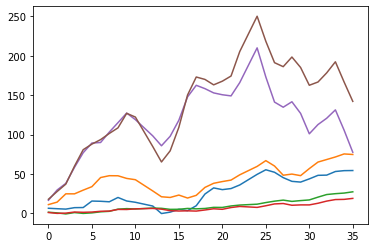

In [882]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test8'

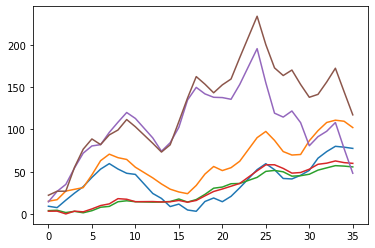

In [879]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test7'

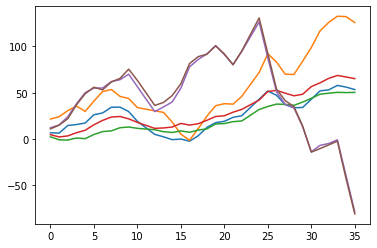

In [872]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test6'

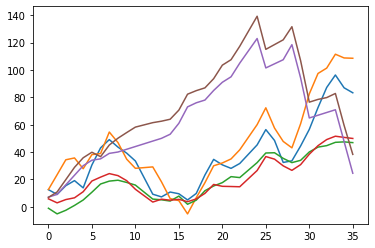

In [870]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test3'

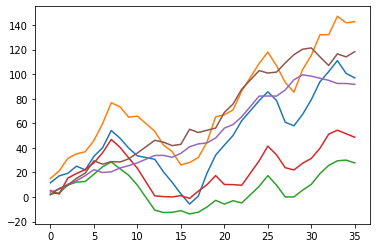

In [861]:
for r in range(6):
    plt.plot(f2[:,r])

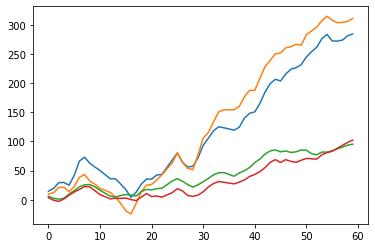

In [856]:
for r in range(4):
    plt.plot(f2[:,r])

In [771]:
np.log2(1)*0.8

0.0

In [777]:
np.e**(0.8)*np.log10(1.5)
10**(1)*np.log10(1.1)
#2**(0.8)*np.log(2.5-1)

0.4139268515822508

In [658]:
for i in range(2013,2019,1):
    for j in range(1,13):
        start_date=datetime(i,j,1) #first day of testing set
        print(start_date)

2013-01-01 00:00:00
2013-02-01 00:00:00
2013-03-01 00:00:00
2013-04-01 00:00:00
2013-05-01 00:00:00
2013-06-01 00:00:00
2013-07-01 00:00:00
2013-08-01 00:00:00
2013-09-01 00:00:00
2013-10-01 00:00:00
2013-11-01 00:00:00
2013-12-01 00:00:00
2014-01-01 00:00:00
2014-02-01 00:00:00
2014-03-01 00:00:00
2014-04-01 00:00:00
2014-05-01 00:00:00
2014-06-01 00:00:00
2014-07-01 00:00:00
2014-08-01 00:00:00
2014-09-01 00:00:00
2014-10-01 00:00:00
2014-11-01 00:00:00
2014-12-01 00:00:00
2015-01-01 00:00:00
2015-02-01 00:00:00
2015-03-01 00:00:00
2015-04-01 00:00:00
2015-05-01 00:00:00
2015-06-01 00:00:00
2015-07-01 00:00:00
2015-08-01 00:00:00
2015-09-01 00:00:00
2015-10-01 00:00:00
2015-11-01 00:00:00
2015-12-01 00:00:00
2016-01-01 00:00:00
2016-02-01 00:00:00
2016-03-01 00:00:00
2016-04-01 00:00:00
2016-05-01 00:00:00
2016-06-01 00:00:00
2016-07-01 00:00:00
2016-08-01 00:00:00
2016-09-01 00:00:00
2016-10-01 00:00:00
2016-11-01 00:00:00
2016-12-01 00:00:00
2017-01-01 00:00:00
2017-02-01 00:00:00


In [641]:
#clf_list = [model1, model2, model3]
eval_scores = [evalscore1, evalscore2, evalscore3, evalscore4, evalscore5, evalscore6, evalscore7, evalscore8, evalscore9]
eval_scores

[8.539091745410117,
 11.124346816409377,
 11.167192226760092,
 9.244380849096924,
 3.9397954705730074,
 10.595257070399821,
 4.134617001377054,
 5.886442409455777,
 1.2478180820867404]

In [651]:
#res[1][:]
#res[1,:][:]
f1 = np.zeros((len(res),4))
f2 = np.zeros((len(res),4))
for i in range(4):
    f1[:,i] = np.array([row[i+1][1] for row in res])
    f2[:,i] = f1[:,i].cumsum()
#f1 = np.array([row[4][1] for row in res])
#f1.cumsum()
f2

array([[  3.8 ,  26.92,   1.68,  -0.58],
       [ 20.42,  60.43,  13.06,   3.87],
       [ 28.89,  71.91,  13.99,   0.45],
       [ 39.53,  94.97,  14.52,   5.37],
       [ 44.45, 109.36,  14.32,   8.81],
       [ 46.66, 102.07,   9.06,   9.54],
       [ 45.9 , 126.29,   0.28,   3.27],
       [ 62.61, 137.07,  12.24,   8.62],
       [ 81.72, 141.85,  24.78,  22.11],
       [ 93.17, 151.79,  33.74,  34.25],
       [101.12, 164.91,  34.06,  36.59],
       [110.47, 175.18,  40.84,  37.6 ],
       [135.47, 209.83,  50.99,  46.97],
       [150.18, 222.79,  51.21,  46.95],
       [170.61, 244.54,  63.77,  56.09],
       [174.93, 262.06,  65.92,  54.49],
       [169.97, 254.54,  65.75,  50.03],
       [166.89, 248.04,  77.14,  59.51]])

In [98]:
pred_test= model1.predict(xgb.DMatrix(xtest,label=None)) 

In [636]:
odds = eval_odds[test_indices]
odds_test_winner = []
data_check_ind =[]
for i in test_indices:
    if i % 2 == 0:
        #odds_test_winner.append(odds[i])
        odds_test_winner.append(eval_odds[i])
        data_check_ind.append(int(i/2))
odds_test_winner

[0.22999999999999998,
 1.44,
 0.22999999999999998,
 1.8599999999999999,
 0.49,
 0.48,
 1.2000000000000002,
 1.0699999999999998,
 0.3600000000000001,
 0.3400000000000001,
 0.3600000000000001,
 0.81,
 0.54,
 0.94,
 1.73,
 0.4099999999999999,
 0.6699999999999999,
 0.69,
 3.0599999999999996,
 0.020000000000000018,
 0.78,
 1.33,
 0.22999999999999998,
 2.3,
 0.030000000000000027,
 2.09,
 1.29,
 1.19,
 0.9299999999999999,
 0.0,
 1.33,
 0.26,
 1.7999999999999998,
 1.23,
 0.3799999999999999,
 0.47,
 1.27,
 1.2000000000000002,
 0.20999999999999996,
 0.3700000000000001,
 1.52,
 1.15,
 0.3500000000000001,
 0.6000000000000001,
 2.5,
 0.74,
 0.42999999999999994,
 0.74,
 0.95,
 0.71,
 0.3899999999999999,
 0.8999999999999999,
 0.75,
 0.24,
 0.3799999999999999,
 0.040000000000000036,
 1.0699999999999998,
 2.24,
 0.21999999999999997,
 0.18999999999999995,
 3.87,
 0.47,
 1.0899999999999999,
 0.6399999999999999,
 1.1800000000000002,
 0.27,
 0.6799999999999999,
 0.56,
 0.9099999999999999,
 1.63,
 0.49,
 0.

In [638]:
data.PSW.iloc[data_check_ind]

29138    1.23
29139    2.44
29140    1.23
29141    2.86
29142    1.49
29143    1.48
29144    2.20
29145    2.07
29146    1.36
29147    1.34
29148    1.36
29149    1.81
29150    1.54
29151    1.94
29152    2.73
29153    1.41
29154    1.67
29155    1.69
29156    4.06
29157    1.02
29158    1.78
29159    2.33
29160    1.23
29161    3.30
29162    1.03
29163    3.09
29164    2.29
29165    2.19
29166    1.93
29167     NaN
         ... 
29608    1.48
29609    1.84
29610    1.52
29611    1.65
29612    1.30
29613    1.52
29614    1.35
29615    1.98
29616    1.68
29617    1.61
29618    1.70
29619    1.74
29620    1.13
29621    2.59
29622    2.86
29623    1.90
29624    1.40
29625    2.33
29626    1.53
29627    2.86
29628    2.12
29629    1.37
29630    2.65
29631    1.52
29632    2.14
29633    2.62
29634    1.60
29635    2.13
29636    3.45
29637    1.71
Name: PSW, Length: 500, dtype: float64

In [58]:
ytest=pd.Series([1,0]*int(len(test_indices)/2))

In [55]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder

In [586]:

#clf_list = [model1, model2, model3]
eval_scores = [evalscore1, evalscore2, evalscore3, evalscore4, evalscore5, evalscore6, evalscore7, evalscore8, evalscore9]
eval_scores
print(evalerror(model4.predict(xgb.DMatrix(xtest,label=None)),0))

('test_gain_error', 45.48315697031096)


In [851]:
class VotingClassifier(object):
    """ Implements a voting classifier for pre-trained classifiers"""

    def __init__(self, estimators):
        self.estimators = estimators

    def predict(self, X, thr = 0.5 ,vote_thr = 0.5, conf_thr = 0.5, log_odd_thr = 0.5):
        # get values
        Y = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i, clf in enumerate(self.estimators):
            if str(type(clf)) == "<class 'xgboost.core.Booster'>":
                preds_in = np.array(clf.predict(xgb.DMatrix(X,label=None)))
                
                preds_dec = np.zeros(len(preds_in))
        
                for k in range(0,len(preds_in)-1,2):
                    if preds_in[k]>preds_in[k+1]:
                        preds_dec[k] = preds_in[k]
                        preds_dec[k+1] = 0
                    else:
                        preds_dec[k] = 0
                        preds_dec[k+1] = preds_in[k+1]
                
                #Y[:, i] = np.array(clf.predict(xgb.DMatrix(X,label=None)))
                Y[:, i] = preds_dec
            else:
                # not further implemented. The Idea was to check if 
                # XGBClassifier gives other / better results
                # the call of it differs to XGB as many others too.
                print('Hallo')
                Y[:, i] = clf.predict_proba(X)
        # apply voting 
        # -------------------------------------------------------
        # log_odd voting
        odds = xtest_0.odds.fillna(1) 
        conf = np.log10(odds)
        Y_log_odd = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i in range(len(self.estimators)):
            Y_log_odd[:, i] = 10**(Y[:, i]) * conf
            
        # log_odd mean voting    
        y_mean_log_odd = np.zeros(X.shape[0])
        y_mean_pr_log_odd = np.mean(Y_log_odd, axis=1)
        y_mean_log_odd[:] = [1 if i >=log_odd_thr else 0 for i in y_mean_pr_log_odd]  
        
        # log_odd majority voting
        y_voting_log_odd = np.zeros(X.shape[0])
        #y_mer = np.zeros(X.shape[0])
        Y_voting_log_odd = np.zeros([X.shape[0], len(self.estimators)], dtype='int')
        for i in range(len(self.estimators)):  
            #K = np.array([1 if i >=conf_thr else 0 for i in Y[:,i]])
            Y_voting_log_odd[:,i] = [1 if i >=log_odd_thr else 0 for i in Y_log_odd[:,i]]
            
        for i in range(X.shape[0]):
            deci = Y_voting_log_odd[i,:].sum()/len(self.estimators)
            y_voting_log_odd[i] = 1 if deci >= vote_thr else 0
        
        
        
        #---------------------------------------------------------
        # odd confidence voting
        odds = xtest_0.odds.fillna(1)        
        conf = 1/odds        
        Y_conf = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i in range(len(self.estimators)):
            Y_conf[:, i] = Y[:, i] * conf
            
        # odd conf mean proba voting
        y_mean_conf = np.zeros(X.shape[0])
        y_mean_pr_conf = np.mean(Y_conf, axis=1)
        y_mean_conf[:] = [1 if i >=conf_thr else 0 for i in y_mean_pr_conf]      

        # majority conf voting
        y_voting_conf = np.zeros(X.shape[0])
        y_mer = np.zeros(X.shape[0])
        Y_voting_conf = np.zeros([X.shape[0], len(self.estimators)], dtype='int')
        for i in range(len(self.estimators)):  
            #K = np.array([1 if i >=conf_thr else 0 for i in Y[:,i]])
            Y_voting_conf[:,i] = [1 if i >=conf_thr else 0 for i in Y_conf[:,i]]
            
        for i in range(X.shape[0]):
            deci = Y_voting_conf[i,:].sum()/len(self.estimators)
            y_voting_conf[i] = 1 if deci >= vote_thr else 0
            
        
        #-----------------------------------------------------------
        # mean proba voting
        y_mean = np.zeros(X.shape[0])
        y_mean_pr = np.mean(Y, axis=1)
        y_mean[:] = [1 if i >=thr else 0 for i in y_mean_pr]
        
        # majority voting
        y_voting = np.zeros(X.shape[0])
        y_mer = np.zeros(X.shape[0])
        Y_voting = np.zeros([X.shape[0], len(self.estimators)], dtype='int')
        for i in range(len(self.estimators)):  
            K = np.array([1 if i >=thr else 0 for i in Y[:,i]])
            Y_voting[:,i] = [1 if i >=thr else 0 for i in Y[:,i]]
            
        for i in range(X.shape[0]):
            deci = Y_voting[i,:].sum()/len(self.estimators)
            y_voting[i] = 1 if deci >= vote_thr else 0
            #y_mer[]
         
        #return Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf
        #return  y_mean,  y_voting, y_mean_pr_conf, y_mean_conf, y_voting_conf
        return  y_mean,  y_voting, y_mean_conf, y_voting_conf, y_mean_log_odd, y_voting_log_odd
        #return y, Y, K, KT

In [844]:
clf_list = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
classif = VotingClassifier(clf_list)
xtest_0=features.iloc[test_indices,:].reset_index(drop=True)
#Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf= classif.predict(xtest, 0.7, vote_thr = (7/9))
y_mean,  y_voting, y_mean_conf, y_voting_conf, y_mean_log_odd, y_voting_log_odd = classif.predict(xtest, 0.6, log_odd_thr = 1.6, vote_thr = (7/9), conf_thr = 0.6)


print(evalerror(y_voting, dtrain)[1])
print(evalerror(y_mean, dtrain))
print(evalerror(y_mean_conf, dtrain))
print(evalerror(y_voting_conf, dtrain))
print(evalerror(y_mean_log_odd, dtrain))
print(evalerror(y_voting_log_odd, dtrain))

3.2399999999999975
('test_o_gain_error', 5.109999999999997)
('test_o_gain_error', 3.969999999999999)
('test_o_gain_error', 1.699999999999999)
('test_o_gain_error', -2.1399999999999997)
('test_o_gain_error', -2.03)


In [817]:
((-0.1/np.log10(0.55)) + (-0.1/np.log10(0.8))+ (-0.1/np.log10(0.55)))/3
np.sqrt(((0.3)**2 + (0.7)**2)/2)
(0.3 + 0.7)/2

0.5

In [846]:
y_voting_log_odd.sum()

3.0

In [249]:
from sklearn.metrics import confusion_matrix

In [466]:
cnf_matrix = confusion_matrix(ytest, y_voting)
cnf_matrix

array([[1840,  160],
       [1318,  682]])

In [351]:
evalerror(y_voting, dtrain)

('test_gain_error', -5.280000000000001)

In [ ]:
class VotingClassifier(object):
    """ Implements a voting classifier for pre-trained classifiers"""

    def __init__(self, estimators):
        self.estimators = estimators

    def predict(self, X, thr = 0.5 ,vote_thr = 0.5):
        # get values
        Y = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i, clf in enumerate(self.estimators):
            if str(type(clf)) == "<class 'xgboost.core.Booster'>":              
                Y[:, i] = np.array(clf.predict(xgb.DMatrix(X,label=None)))
            else:
                print('Hallo')
                Y[:, i] = clf.predict_proba(X)
        # apply voting 
        
        # mean proba voting
        
        y_mean = np.zeros(X.shape[0])
        y_mean_pr = np.mean(Y, axis=1)
        y_mean = [1 if i >=thr else 0 for i in y_mean_pr]
        
        
        y_voting = np.zeros(X.shape[0])
        y_mer = np.zeros(X.shape[0])
        Y_voting = np.zeros([X.shape[0], len(self.estimators)], dtype='int')
        for i in range(len(self.estimators)):  
            K = np.array([1 if i >=thr else 0 for i in Y[:,i]])
            Y_voting[:,i] = [1 if i >=thr else 0 for i in Y[:,i]]
            
        for i in range(X.shape[0]):
            deci = Y_voting[i,:].sum()/len(self.estimators)
            y_voting[i] = 1 if deci >= vote_thr else 0
            #y_mer[]
         
        return Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci
        #return y, Y, K, KT

In [732]:
def evalerror(preds, dtrain):
#thr = 0.5
    #labels = dtrain.get_label()
    global eval_odds
    global train_indices
    global val_indices
    global test_indices
    
    #print(preds[0:10])


    if len(preds) == len(train_indices):
        odds = eval_odds[train_indices]
        gain = odds * preds       
        return 'train_gain_error', -gain.sum()
    elif len(preds) == len(val_indices):
        odds = eval_odds[val_indices]
        gain = odds * preds 
        return 'val_gain_error', -gain.sum()
    elif len(preds) == len(test_indices):
        odds = eval_odds[test_indices]
        gain = odds * preds 
        #return 'test_o_gain_error', -gain.sum(), odds
        return 'test_o_gain_error', -gain.sum()
    else:
        return 'function_error', 0

In [540]:
features.columns

Index(['odds', 'odds_opp', 'cat_feature_0', 'cat_feature_1', 'cat_feature_2',
       'cat_feature_3', 'cat_feature_4', 'cat_feature_5', 'cat_feature_6',
       'cat_feature_7',
       ...
       'recentft_150_1_opp', 'recentft_150_2_opp', 'recentft_150_3_opp',
       'recentft_150_4_opp', 'recentft_150_5_opp', 'recentft_150_6_opp',
       'recentft_150_7_opp', 'recentft_150_8_opp', 'recentft_150_9_opp',
       'recentft_150_10_opp'],
      dtype='object', length=246)